# Kriging and Shapley Value Computation on Geohash Level

**Author**: Matthew Samuel  
**Date**: June 2025

## Description

This Jupyter Notebook performs Kriging interpolation and data valuation using Shapley values at the **GeoHash level** (Scenario 1). The analysis is conducted using a parallelized framework based on Dask to efficiently process a large number of targets.

For each selected Geohash (target):
- A Kriging prediction is computed using spatially neighboring cells.
- The model then evaluates the contribution of each neighbor through **Shapley values**, approximated using **Truncated Structured Sampling (TSS)**.

The notebook supports **batch processing of multiple target Geohashes**. The final results are compiled into a CSV file and saved in the `/Output` directory.

Additionally, summary plots and graphs are generated at the end to aid in interpretation and visualization of the interpolation and data valuation results.

In [1]:
# imports
import pandas as pd
import numpy as np
import time
import importlib
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import config
import FrameworkGEO as fw
importlib.reload(fw)

<module 'FrameworkGEO' from '/Users/matthewsamuel1/Desktop/madrid/SHAPwithEVENTS/shapely/geohashLevel/FrameworkGEO.py'>

In [2]:
client = Client(n_workers=8, threads_per_worker=1, memory_limit='3.5GB')
config.daskClient = client
print("Dask dashboard:", client.dashboard_link)

Dask dashboard: http://127.0.0.1:8787/status


In [3]:
input             = "input/input_data_1m.csv"                   # Path to test data 
missing_geohashes = "input/Madrid_centro_missing_ghashes.csv"   # Path to missing geohashes 
groundtruth       = "input/groundtruth_12m.csv"                 # Path to ground truth 

sel_freq = "1800"                                               # Frequency band (e.g., LTE-1800)
empty_geohashes_to_predict = 1                                  # Number of empty geohashes to predict

In [4]:
# initialize combinder and scatter heavy objects
combiner = fw.KrigingDataCombination(input_path=input,missing_geohashes=missing_geohashes,sel_freq="1800")
combiner_fut = client.scatter(combiner, broadcast=True)
val_fn = fw.KrigingValueFunction(ground_truth_path=groundtruth)
val_fn_fut = client.scatter(val_fn, broadcast=True)

In [ ]:
print(combiner.df1.head()) 
combiner.df1.count()

In [ ]:
print(combiner.df2.head())
combiner.df2.count()


In [5]:
# Build sorted geohashes list by neighbor count
sorted_geohashes = sorted(
    combiner.df1["geohash"].unique(),
    key=lambda gh: len(combiner.get_neighbors(gh)),
    reverse=False
)

# Parameters for selecting target geohashes
empty_geohashes_to_predict = 1  # Number of empty geohashes to predict
target_index = 0                # Starting index in the sorted geohash list


# Determine the target geohashes slice
target_geohashes = sorted_geohashes[
    target_index : target_index + empty_geohashes_to_predict
]

In [6]:
# -------------------------------------------
# 2. Kriging Predictions
# -------------------------------------------

results = []
for target_gh in target_geohashes:
    try:
        # Step 1: Initialize model with target geohash
        model = fw.KrigingModel(combiner, target_geohash=target_gh)

        # Step 2: Make prediction (without getCombinedInput)
        prediction = model.getModelOutput()
        
        if not prediction:
            print(f"⚠️ No prediction possible for {target_gh}")
            continue
            
        # Step 3: Collect basic information about the target
        target_data = combiner.df1[combiner.df1["geohash"] == target_gh].iloc[0]
        
        # Step 4: Store results
        results.append({
            "geohash": target_gh,
            "latitude": target_data["latitude"],
            "longitude": target_data["longitude"],
            "predicted_rsrp": prediction["prediction"],
            "variance": prediction["variance"],
            "neighbors": len(model.neighbors_df)
        })
        
    except Exception as e:
        print(f"❌ Error for {target_gh}: {str(e)}")

In [7]:

print("Variogram params - C0:", model.C0, "C1:", model.C1, "alpha:", model.alpha, "R:", model.R)  # Debug

Variogram params - C0: 5 C1: 106.33319315473324 alpha: 4.6 R: 100


In [8]:
# Show results
if results:
    df_results = pd.DataFrame(results)
    print("                          Prediction results")
    print("------------------------------------------------------------------------")
    print(df_results)
    print("------------------------------------------------------------------------")
else:
    print("\nNo predictions possible - check input data")

                          Prediction results
------------------------------------------------------------------------
    geohash   latitude  longitude  predicted_rsrp   variance  neighbors
0  ezjqh1dt  40.438871  -3.687801      -89.751615  86.350915         25
------------------------------------------------------------------------


In [9]:
# -------------------------------------------
# 3. SHAPLEY
# -------------------------------------------

shapResults = []

for target_gh in target_geohashes:
    print("========================================================")
    print(f"Shapley computation (TSS) for target: {target_gh}")

    # Create a KrigingModel in Shapley mode
    model = fw.KrigingModel(combiner, target_gh, use_shapley_mode=True)
    model_fut = client.scatter(model, broadcast=True)

    # Create a new vbdeFramework (with buffering) using Dask futures
    framework = fw.vbdeFramework(
        iCombiner=combiner_fut,
        iModel=model_fut,
        iValueFunction=val_fn_fut
    )

    # Retrieve the subindices (neighbors) associated with this target
    subindices = combiner.getSources(target_gh)
    if not subindices:
        print("No neighbors found for this geohash, skipping...\n")
        continue

    # Define TSS parameters
    r = 200                # Number of rounds (more rounds typically yield better results)
    trunc_value = -0.01    # Truncation threshold for marginal contributions

    # Compute the Shapley values using Truncated Structured Sampling (parallel)
    shapley_tss, dfPerms, nExecs = framework.getTSS_parallel(
        config.daskClient,
        framework.WorkerProcess_init,
        subindices,
        r,
        trunc_value
    )

    # Get the evaluation (-RMSE) for the full coalition (all neighbors combined)
    full_coalition = tuple(sorted(subindices))
    prediction_full_eval = framework.evaluateTuple(full_coalition)
    print(f"Negative RMSE for geohash {target_gh}: {prediction_full_eval}")

    # Get the raw RSRP prediction for the full coalition
    combined_input = combiner.getCombinedInput(target_gh, full_coalition)
    rsrp_prediction = model.getModelOutput(combined_input)["prediction"]
    print(f"RSRP prediction for geohash {target_gh}: {rsrp_prediction}")
    print("\n")

    # Compile Shapley values per neighbor and construct the output DataFrame
    neighbors_df = combiner.get_neighbors(target_gh).copy()
    neighbors_df['shapley_value'] = neighbors_df['subindex'].apply(lambda x: shapley_tss.get(x, np.nan))
    neighbors_output = neighbors_df[['geohash_y', 'shapley_value', 'longitude_y', 'latitude_y', 'events', 'value']].rename(
        columns={
            'geohash_y': 'geohash',
            'longitude_y': 'longitude',
            'latitude_y': 'latitude',
            'value': 'value'
        }
    )

    # Add a "role" column and set it to nan for neighbors
    neighbors_output['role'] = np.nan

    # Retrieve the target metadata from combiner.df1
    target_data = combiner.df1[combiner.df1["geohash"] == target_gh].iloc[0]
    target_row = pd.DataFrame({
        "geohash": [target_gh],
        "shapley_value": [np.nan],
        "longitude": [target_data["longitude"]],
        "latitude": [target_data["latitude"]],
        "events": [np.nan],
        "role": ["target"]
    })

    # Combine neighbor rows and target row into one DataFrame
    neighbor_shap_df = pd.concat([neighbors_output, target_row], ignore_index=True)

    # Display neighbors and their Shapley values
    print("Used neighbors and their TSS Shapley Value:")
    shapsum = 0
    for si in subindices:
        shap_val = shapley_tss.get(si, "n/a")
        if shap_val == "n/a":
            shap_val = np.nan
        shapsum += shap_val if not np.isnan(shap_val) else 0
        print(f"  Neighbor {si}: {shap_val}")

    # Check Shapley efficiency: sum of SVs vs. v(N)
    shapsum_rounded = round(shapsum, 8)
    vN_rounded = round(prediction_full_eval, 8)
    sv_check = (shapsum_rounded == vN_rounded)

    print("\n")
    print("Shapley sum vs. v(N):", shapsum_rounded, ",", vN_rounded)
    print("Is equal =", sv_check)

    # Calculate total possible evaluateTuple calls without truncation
    total_calls = len(dfPerms) * len(subindices)
    calls_saved = total_calls - nExecs

    # Store current results
    shapResults.append({
        "target_geohash": target_gh,
        "rsrp_prediction": rsrp_prediction,
        "negative RMSE": prediction_full_eval,
        "number_of_neighbors": len(subindices),
        "neighbor_shapley_values": neighbor_shap_df,
        "total_shapley": shapsum,
        "sv_check": sv_check,
        "nExecs": nExecs,
        "nPermutations": len(dfPerms),
        "calls_saved": calls_saved       
    })

    print("\n")
    print(f"Number of evaluateTuple calls (nExecs): {nExecs}")
    print(f"Number of generated permutations: {len(dfPerms)}\n")

shapResults_df = pd.DataFrame(shapResults)

Shapley computation (TSS) for target: ezjqh1dt


Shapley progress: 100%|██████████| 25/25 [01:06<00:00,  2.67s/chunk, avg=2.7s, ETA=0:00:00]


Negative RMSE for geohash ezjqh1dt: -4.342979331904743
RSRP prediction for geohash ezjqh1dt: -89.75161526268985


Used neighbors and their TSS Shapley Value:
  Neighbor 1: 0.9073664348636438
  Neighbor 2: -2.1910734557945504
  Neighbor 3: -0.15615901864038284
  Neighbor 4: 1.7307250372626561
  Neighbor 5: 0.5095122345067622
  Neighbor 6: -0.20180480448740332
  Neighbor 7: 0.08876345379503735
  Neighbor 8: 0.4952352674660444
  Neighbor 9: -0.4127400388935438
  Neighbor 10: 0.40195194498558035
  Neighbor 11: -0.24424104832294954
  Neighbor 12: -0.5743727952582108
  Neighbor 13: 0.15157270554580168
  Neighbor 14: -0.6277079264472507
  Neighbor 15: 0.3978272743259076
  Neighbor 16: 0.42190893939306473
  Neighbor 17: -0.8271911914037314
  Neighbor 18: -1.7122750095319488
  Neighbor 19: 0.31874933868756716
  Neighbor 20: -0.897300546192651
  Neighbor 21: -0.31330044959367387
  Neighbor 22: -1.6606881882110673
  Neighbor 23: -0.7232438745334652
  Neighbor 24: 0.3231844373977868
  Neighbor 25:

In [10]:
shapResults_df

,target_geohash,rsrp_prediction,negative RMSE,number_of_neighbors,neighbor_shapley_values,total_shapley,sv_check,nExecs,nPermutations,calls_saved
0,ezjqh1dt,-89.751615,-4.342979,25,geohash shapley_value longitude latit...,-4.283534,False,91241,5000,33759


In [11]:
total_neg_RMSE = shapResults_df["negative RMSE"].sum()
print("Sum of all -RMSE:", total_neg_RMSE)

Sum of all -RMSE: -4.342979331904743


In [12]:
output = shapResults_df["neighbor_shapley_values"][0]
output

,geohash,shapley_value,longitude,latitude,events,value,role
0,ezjqh1dw,0.907366,-3.687801,40.439040,7.0,-92.285714,NaN
1,ezjqh1ds,-2.191073,-3.687801,40.438698,1.0,-81.000000,NaN
2,ezjqh1dv,-0.156159,-3.687458,40.438873,1.0,-90.000000,NaN
3,ezjqh1dy,1.730725,-3.687458,40.439040,5.0,-108.200000,NaN
4,ezjqh1du,0.509512,-3.687458,40.438698,1.0,-93.000000,NaN
5,ezjqh1dx,-0.201805,-3.687801,40.439217,5.0,-88.800000,NaN
6,ezjqh1dr,0.088763,-3.688145,40.439217,10.0,-89.600000,NaN
7,ezjqh1dz,0.495235,-3.687458,40.439217,2.0,-97.500000,NaN
8,ezjqh1f2,-0.412740,-3.688145,40.439384,4.0,-86.250000,NaN
9,ezjqh1fb,0.401952,-3.687458,40.439384,3.0,-94.000000,NaN


In [13]:
output.to_csv('output/output_shapleyGEOlevel.csv')

***Graphing***

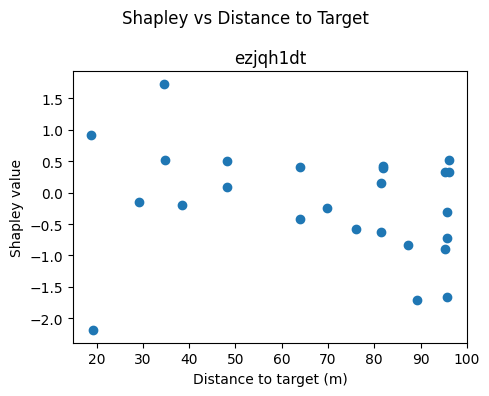

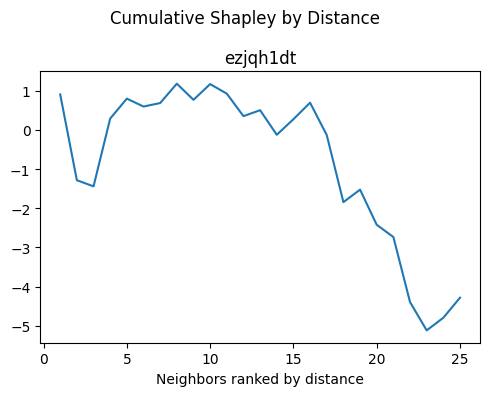

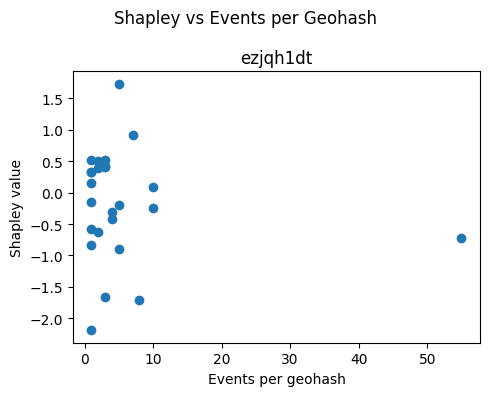

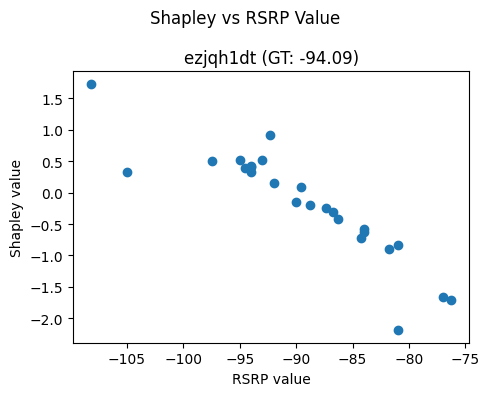

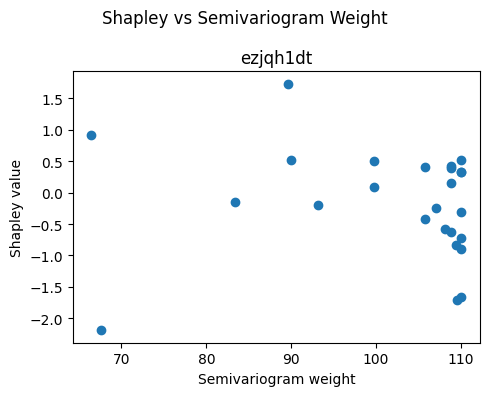

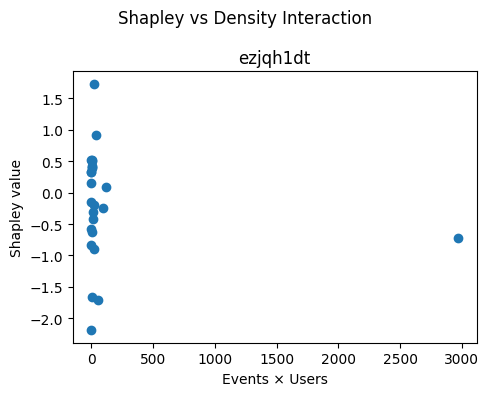

In [14]:
# Precompute user counts for density interaction
try:
    raw_df = pd.read_csv(input)
    if 'user_id' in raw_df.columns:
        user_counts = raw_df.groupby('gps_geohash_08')['user_id'].nunique()
    else:
        user_counts = combiner.df2.set_index('geohash')['events']
except Exception:
    user_counts = combiner.df2.set_index('geohash')['events']

# Determine number of targets
n_targets = len(shapResults_df)

# Plot configuration: (feature, xlabel, title)
plot_config = [
    ('distance', 'Distance to target (m)', 'Shapley vs Distance to Target'),
    ('cumulative_shapley', 'Neighbors ranked by distance', 'Cumulative Shapley by Distance'),
    ('events', 'Events per geohash', 'Shapley vs Events per Geohash'),
    ('value', 'RSRP value', 'Shapley vs RSRP Value'),
    ('semivariogram_weight', 'Semivariogram weight', 'Shapley vs Semivariogram Weight'),
    ('density', 'Events × Users', 'Shapley vs Density Interaction'),
]

for feature, xlabel, title in plot_config:
    fig, axes = plt.subplots(1, n_targets, figsize=(5 * n_targets, 4), squeeze=False)
    for ax, (_, row) in zip(axes[0], shapResults_df.iterrows()):
        df = row['neighbor_shapley_values']
        if feature == 'events':
            x = df['events']
            y = df['shapley_value']
            ax.scatter(x, y)
        elif feature == 'distance':
            dist_df = combiner.get_neighbors(row['target_geohash'])[['geohash_y','distance']].rename(columns={'geohash_y':'geohash'})
            df_dist = pd.merge(df, dist_df, on='geohash')
            x = df_dist['distance']
            y = df_dist['shapley_value']
            ax.scatter(x, y)
        elif feature == 'value':
            x = df['value']
            y = df['shapley_value']
            ax.scatter(x, y)
        elif feature == 'semivariogram_weight':
            dist_df = combiner.get_neighbors(row['target_geohash'])[['geohash_y','distance']].rename(columns={'geohash_y':'geohash'})
            df_dist = pd.merge(df, dist_df, on='geohash')
            x = combiner.sv(df_dist['distance'])
            y = df_dist['shapley_value']
            ax.scatter(x, y)
        elif feature == 'cumulative_shapley':
            dist_df = combiner.get_neighbors(row['target_geohash'])[['geohash_y','distance']].rename(columns={'geohash_y':'geohash'})
            df_dist = pd.merge(df, dist_df, on='geohash').sort_values('distance')
            cumsum = df_dist['shapley_value'].cumsum()
            x = range(1, len(cumsum) + 1)
            y = cumsum.values
            ax.plot(x, y)
        elif feature == 'density':
            density = df['events'] * df['geohash'].map(user_counts)
            x = density
            y = df['shapley_value']
            ax.scatter(x, y)
        # Set title, with ground truth for RSRP value
        if feature == 'value':
            gt_val = val_fn.ground_truth.loc[
                val_fn.ground_truth['geohash'] == row['target_geohash'], 'value'
            ].iloc[0]
            ax.set_title(f"{row['target_geohash']} (GT: {gt_val:.2f})")
        else:
            ax.set_title(row['target_geohash'])
        ax.set_xlabel(xlabel)
        if feature != 'cumulative_shapley':
            ax.set_ylabel('Shapley value')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()